# 一、前期工作

本文将采用`AlexNet`实现鸟类图片的识别分类

🔥本文 GitHub [https://github.com/kzbkzb/Python-AI](https://github.com/kzbkzb/Python-AI) 已收录

- 作者：[K同学啊](https://mp.weixin.qq.com/s/NES9RhtAhbX_jsmGua28dA)
- 来自专栏：《深度学习100例》-Tensorflow2版本
- 数据链接：https://pan.baidu.com/s/1LfiEQ43HhSsm7qU3KOM0Bg （提取码：0mhm）

我的环境：

- 语言环境：Python3.6.5
- 编译器：jupyter notebook
- 深度学习环境：TensorFlow2.4.1

## 1. 设置GPU

如果使用的是CPU可以注释掉这部分的代码。

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpus[0]],"GPU")

## 2. 导入数据

In [2]:
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

import os,PIL

# 设置随机种子尽可能使结果可以重现
import numpy as np
np.random.seed(1)

# 设置随机种子尽可能使结果可以重现
import tensorflow as tf
tf.random.set_seed(1)

import pathlib

In [3]:
data_dir = "D:/jupyter notebook/DL-100-days/datasets/bird_photos"

data_dir = pathlib.Path(data_dir)

## 3. 查看数据

In [4]:
image_count = len(list(data_dir.glob('*/*')))

print("图片总数为：",image_count)

图片总数为： 565


# 二、数据预处理

|文件夹|数量|
|:--:|:--:|
|Bananaquit|	166 张
|Black Throated Bushtiti|	111 张
|Black skimmer|		122 张
|Cockatoo|	166张

## 1. 加载数据

使用`image_dataset_from_directory`方法将磁盘中的数据加载到`tf.data.Dataset`中

In [5]:
batch_size = 8
img_height = 227
img_width = 227

TensorFlow版本是2.2.0的同学可能会遇到`module 'tensorflow.keras.preprocessing' has no attribute 'image_dataset_from_directory'`的报错，升级一下TensorFlow就OK了。

In [6]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 565 files belonging to 4 classes.
Using 452 files for training.


In [7]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 565 files belonging to 4 classes.
Using 113 files for validation.


我们可以通过class_names输出数据集的标签。标签将按字母顺序对应于目录名称。

In [8]:
class_names = train_ds.class_names
print(class_names)

['Bananaquit', 'Black Skimmer', 'Black Throated Bushtiti', 'Cockatoo']


## 2. 可视化数据

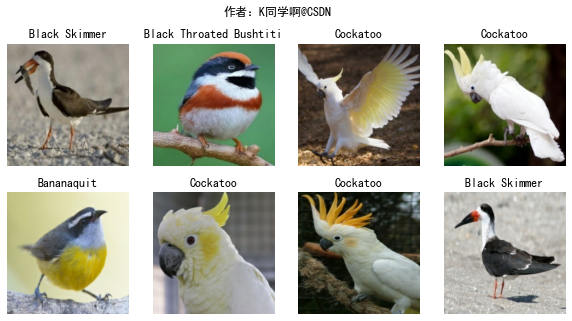

In [9]:
plt.figure(figsize=(10, 5))  # 图形的宽为10高为5
plt.suptitle("作者：K同学啊@CSDN")

for images, labels in train_ds.take(1):
    for i in range(8):
        
        ax = plt.subplot(2, 4, i + 1)  

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        
        plt.axis("off")

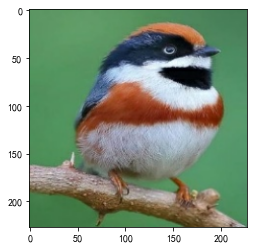

In [10]:
plt.imshow(images[1].numpy().astype("uint8"))

## 3. 再次检查数据 

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(8, 227, 227, 3)
(8,)


- `Image_batch`是形状的张量（8, 224, 224, 3)。这是一批形状240x240x3的8张图片（最后一维指的是彩色通道RGB）。 
- `Label_batch`是形状（8，）的张量，这些标签对应8张图片

## 4. 配置数据集

- **shuffle()** ： 打乱数据，关于此函数的详细介绍可以参考：https://zhuanlan.zhihu.com/p/42417456
- **prefetch()** ：预取数据，加速运行，其详细介绍可以参考我前两篇文章，里面都有讲解。
- **cache()** ：将数据集缓存到内存当中，加速运行

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 三、AlexNet (8层）介绍

AleXNet使用了ReLU方法加快训练速度，并且使用Dropout来防止过拟合

`AleXNet (8层）`是首次把卷积神经网络引入计算机视觉领域并取得突破性成绩的模型。获得了ILSVRC 2012年的冠军，再top-5项目中错误率仅仅15.3%，相对于使用传统方法的亚军26.2%的成绩优良重大突破。和之前的LeNet相比，AlexNet通过堆叠卷积层使得模型更深更宽。

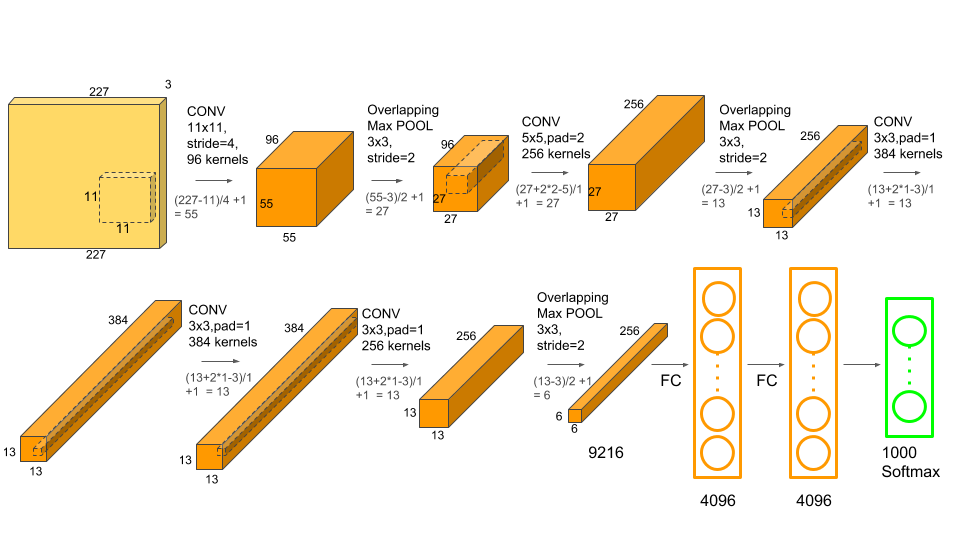

关于上面卷积的计算还比较蒙的同学可以参考我这篇文章哈：[卷积的计算](https://blog.csdn.net/qq_38251616/article/details/114278995)

# 四、构建AlexNet (8层）网络模型

下面是本文的重点，可以试着按照上面三张图自己构建一下ResNet-50

In [13]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization,Activation

import numpy as np
seed = 7
np.random.seed(seed)

def AlexNet(nb_classes, input_shape):
    input_tensor = Input(shape=input_shape)
    # 1st block
    x = Conv2D(96, (11,11), strides=4, name='block1_conv1')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3,3), strides=2, name = 'block1_pool')(x)
    
    # 2nd block
    x = Conv2D(256, (5,5), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3,3), strides=2, name='block2_pool')(x)
    
    # 3rd block
    x = Conv2D(384, (3,3), activation='relu', padding='same',name='block3_conv1')(x)
    # 4th block
    x = Conv2D(384, (3,3), activation='relu', padding='same',name='block4_conv1')(x)
    
    # 5th block
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='block5_conv1')(x)
    x = MaxPooling2D((3,3), strides=2, name = 'block5_pool')(x)
    
    # full connection
    x = Flatten()(x)
    x = Dense(4096, activation='relu',  name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    output_tensor = Dense(nb_classes, activation='softmax', name='predictions')(x)

    model = Model(input_tensor, output_tensor)
    return model

model=AlexNet(1000, (img_width, img_height, 3))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 55, 55, 96)        0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 27, 27, 96)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024  

# 五、编译

在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：

- 损失函数（loss）：用于衡量模型在训练期间的准确率。
- 优化器（optimizer）：决定模型如何根据其看到的数据和自身的损失函数进行更新。
- 指标（metrics）：用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

In [14]:
# 设置优化器，我这里改变了学习率。
# opt = tf.keras.optimizers.Adam(learning_rate=1e-7)

model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 六、训练模型

In [15]:
epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 5s 30ms/step - loss: 9.2789 - accuracy: 0.2166 - val_loss: 3.2340 - val_accuracy: 0.3363
Epoch 2/20
57/57 [==============================] - 1s 14ms/step - loss: 0.9329 - accuracy: 0.6224 - val_loss: 1.1778 - val_accuracy: 0.5310
Epoch 3/20
57/57 [==============================] - 1s 14ms/step - loss: 0.7438 - accuracy: 0.6747 - val_loss: 1.9651 - val_accuracy: 0.5133
Epoch 4/20
57/57 [==============================] - 1s 14ms/step - loss: 0.8875 - accuracy: 0.7025 - val_loss: 1.5589 - val_accuracy: 0.4602
Epoch 5/20
57/57 [==============================] - 1s 14ms/step - loss: 0.6116 - accuracy: 0.7424 - val_loss: 0.9914 - val_accuracy: 0.4956
Epoch 6/20
57/57 [==============================] - 1s 15ms/step - loss: 0.6258 - accuracy: 0.7520 - val_loss: 1.1103 - val_accuracy: 0.5221
Epoch 7/20
57/57 [==============================] - 1s 13ms/step - loss: 0.5138 - accuracy: 0.8034 - val_loss: 0.7832 - val_accuracy: 0.6726
Epoch 8/20
57

# 七、模型评估

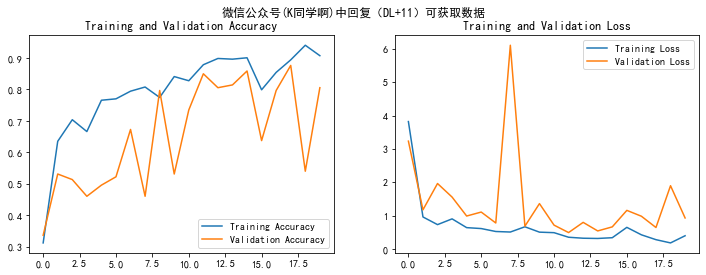

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.suptitle("微信公众号(K同学啊)中回复（DL+11）可获取数据")

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 八、保存and加载模型

这是最简单的模型保存与加载方法哈

In [17]:
# 保存模型
model.save('model/my_model.h5')

In [18]:
# 加载模型
new_model = tf.keras.models.load_model('model/my_model.h5')

# 九、预测

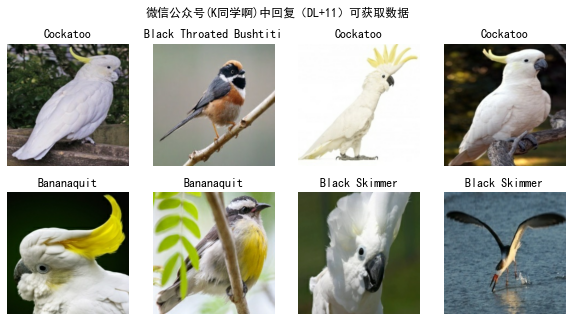

In [19]:
# 采用加载的模型（new_model）来看预测结果

plt.figure(figsize=(10, 5))  # 图形的宽为10高为5
plt.suptitle("微信公众号(K同学啊)中回复（DL+11）可获取数据")

for images, labels in val_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)  
        
        # 显示图片
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(images[i], 0) 
        
        # 使用模型预测图片中的人物
        predictions = new_model.predict(img_array)
        plt.title(class_names[np.argmax(predictions)])

        plt.axis("off")